In [1]:
import time
import subprocess

# Start time
start_time = time.time()

# Command to run
command = [
    "gdallocationinfo", "-wgs84",
    "/home/patrickb/litus/data/ESA_WORLDCOVER/ESA_WorldCover_10m_2021_v200_N00E006_Map.tif",
    "6.5", "0.5"
]

# Run the command
subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# End time
end_time = time.time()

# Calculate elapsed time in seconds and convert to milliseconds
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time: {elapsed_time_ms} ms")


Elapsed time: 363.80863189697266 ms


In [3]:
import rasterio

# File path to the raster dataset
file_path = "/home/patrickb/litus/data/ESA_WORLDCOVER/ESA_WorldCover_10m_2021_v200_N00E006_Map.tif"

# Coordinates to query
longitude = 6.5
latitude = 0.5

# Open the raster file using rasterio
start_time = time.time()
with rasterio.open(file_path) as dataset:
    # Convert geographic coordinates to image coordinates (row, col)
    row, col = dataset.index(longitude, latitude)

    # Read the pixel value at the given row and col
    value = dataset.read(1)[row, col]

    print(f"Value at ({longitude}, {latitude}): {value}")

end_time = time.time()

# Calculate elapsed time in seconds and convert to milliseconds
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time: {elapsed_time_ms} ms")

Value at (6.5, 0.5): 80
Elapsed time: 2186.3675117492676 ms


In [4]:
import rasterio

file_path = "/home/patrickb/litus/data/ESA_WORLDCOVER/ESA_WorldCover_10m_2021_v200_N00E006_Map.tif"

# Open the dataset and load the raster band into memory
with rasterio.open(file_path) as dataset:
    band_data = dataset.read(1)  # Read the entire raster band into memory

    # Now, you can quickly query values from the in-memory array
    def query_value(lon, lat):
        row, col = dataset.index(lon, lat)
        return band_data[row, col]

    # Example usage
    print(query_value(6.5, 0.5))


80


In [5]:
import numpy as np
import rasterio

# File path to the raster dataset
file_path = "/home/patrickb/litus/data/ESA_WORLDCOVER/ESA_WorldCover_10m_2021_v200_N00E006_Map.tif"

# Open the raster dataset
with rasterio.open(file_path) as dataset:
    # Read the entire raster band into a NumPy array
    band_data = dataset.read(1)

    # Save the NumPy array to a .npy file
    np.save("worldcover_band_data.npy", band_data)

    # Save the geotransform for future coordinate translation
    np.save("worldcover_geotransform.npy", dataset.transform)


In [6]:
import h5py
import rasterio

# File path to the raster dataset
file_path = "/home/patrickb/litus/data/ESA_WORLDCOVER/ESA_WorldCover_10m_2021_v200_N00E006_Map.tif"

# Open the raster dataset and write it to an HDF5 file
with rasterio.open(file_path) as dataset:
    band_data = dataset.read(1)
    geotransform = dataset.transform

    # Save to HDF5
    with h5py.File('worldcover_data.h5', 'w') as hdf:
        hdf.create_dataset('band_data', data=band_data)
        hdf.create_dataset('geotransform', data=geotransform)


In [1]:
import h5py
import rasterio.transform

# Load the HDF5 file
def test():
    start = time.time()
    with h5py.File('/home/patrickb/litus/data/h5s/Ai2_WorldCover_10m_2024_v1_N00E010_Map.h5', 'r') as hdf:
        band_data = hdf['band_data']
        geotransform = hdf['geotransform'][:]

        # Function to query the value from HDF5 using lat/lon
        def query_value(lon, lat):
            # Convert geographic coordinates to image coordinates (row, col)
            row, col = ~rasterio.transform.Affine(*geotransform) * (lon, lat)
            return band_data[int(row), int(col)]

        # Query an example coordinate
        lon, lat = 6.5, 0.5
        print(query_value(lon, lat))
    # End time

    # Calculate elapsed time in seconds and convert to milliseconds


In [2]:
%timeit test

16.4 ns ± 0.384 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [3]:
test()


NameError: name 'time' is not defined

In [ ]:
import os
import pandas as pd

# Directory containing the CSV files
directory_path = '/home/patrickb/litus/src/coastal_data_points'
def find_csv_with_most_rows(directory):
    max_rows = 0
    largest_file = None

    # Iterate through all CSV files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            try:
                # Count rows without loading the full data into memory
                row_count = len(pd.read_csv(file_path))
                if row_count > max_rows:
                    max_rows = row_count
                    largest_file = filename
                    print(largest_file)
            except:
                pass
    return largest_file, max_rows

# Find the file with the most rows
largest_csv, max_rows = find_csv_with_most_rows(directory_path)
print(f"The file with the most rows is {largest_csv} with {max_rows} rows.")


ESA_WorldCover_10m_2021_v200_N09W018_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N57E057_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N39E069_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N36E069_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N72E114_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N66W162_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N57W111_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N48W075_Map_coast.csv
ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv


In [5]:
len(df)

45093018

array([60., 60., 60., 60., 60., 60., 60., 60., 60., 60.])

In [9]:
import pandas as pd
import numpy as np
from numba import njit

# Optimized Haversine function with Numba JIT compilation
@njit
def haversine_numba(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Distance in kilometers

# Load CSV containing coastal points (with 'latitude' and 'longitude' columns)
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
df = pd.read_csv(csv_path)

# Define the sample point (latitude and longitude)
sample_lat, sample_lon = 51.5074, -0.1278  # Example: London


In [10]:
n_points = 1000000
# Apply the optimized haversine function to all points
start = time.time()
haversine_numba(df['latitude'].values[:n_points], df['longitude'].values[:n_points], sample_lat, sample_lon)
end = time.time()

print("Time taken:", end - start)


Time taken: 1.1384046077728271


In [11]:
# Apply the optimized haversine function to all points
start = time.time()
df['haversine_distance_km'] = haversine_numba(df['latitude'].values, df['longitude'].values, sample_lat, sample_lon)
end = time.time()

In [42]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from math import radians

# Load the CSV containing coastal points (with 'latitude' and 'longitude' columns)
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
df = pd.read_csv(csv_path)

# Convert latitude and longitude to radians (required for Haversine metric)
# df['latitude_rad'] = np.radians(df['latitude'].sample(10000))
# df['longitude_rad'] = np.radians(df['longitude'].sample(10000))

# Define the sample point (latitude and longitude) and convert to radians
sample_lat, sample_lon = 51.5074, -0.1278  # Example: London
sample_point_rad = [[radians(sample_lat), radians(sample_lon)]]

# Prepare the coastal points in radians for BallTree


# Build the BallTree with Haversine metric
tree = BallTree(np.radians(df[['latitude', 'longitude']].sample(1000000)), metric='haversine')

joblib.dump(tree, 'coastal_ball_tree.joblib')
print("BallTree saved successfully.")
# Load the saved BallTree
start = time.time()
tree = joblib.load('coastal_ball_tree.joblib')
distance_rad, index = tree.query(sample_point_rad, k=1)
distance_km = distance_rad[0][0] * 6371.0
nearest_point = df.iloc[index[0][0]]
end = time.time()
print(end-start)
# Convert distance from radians to kilometers (Earth's radius ~6371 km)


print(f"Nearest point: {nearest_point[['latitude', 'longitude']].values}, Minimum Haversine distance: {distance_km} km")

BallTree saved successfully.
0.010579109191894531
Nearest point: [ 59.956917 -70.95417 ], Minimum Haversine distance: 4230.39047838219 km


['coastal_balltree.z']

/usr/lib/python3.12/contextlib.py:137: UserWarning: mmap_mode "r" is not compatible with compressed file coastal_balltree.z. "r" flag will be ignored.
  return next(self.gen)


ValueError: mmap length is greater than file size

In [32]:
import joblib
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd
from math import radians


joblib.dump(tree, 'coastal_ball_tree.joblib')
print("BallTree saved successfully.")
# Load the saved BallTree
start = time.time()
tree = joblib.load('coastal_ball_tree.joblib')
print("BallTree loaded successfully.")
end = time.time()


0.5742959976196289


In [25]:
start = time.time()
distance, index = tree.query([sample_lat, sample_lon], k=1)
print(time.time() - start)

0.0006651878356933594


In [23]:
import pandas as pd
import numpy as np
from numba import njit

# Numba-optimized Euclidean distance calculation

def euclidean_distance(lat1, lon1, latitudes, longitudes):
    distances = np.sqrt((latitudes - lat1) ** 2 + (longitudes - lon1) ** 2)
    return distances

# Load CSV containing coastal points (with 'latitude' and 'longitude' columns)
# Load CSV containing coastal points (with 'latitude' and 'longitude' columns)
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
df = pd.read_csv(csv_path)

# Define the sample point (latitude and longitude)

# Define the sample point (latitude and longitude)
sample_lat, sample_lon = 51.5074, -0.1278  # Example: London

# Calculate Euclidean distances between the sample point and all points in the CSV
start = time.time()
df['euclidean_distance'] = euclidean_distance(sample_lat, sample_lon, df['latitude'].values[1:100000], df['longitude'].values[1:100000])
end = time.time()
# Print the first few rows to inspect
print(df[['latitude', 'longitude', 'euclidean_distance']].head())

# Optionally, save the result to a new CSV


ValueError: Length of values (99999) does not match length of index (45093018)

In [22]:
print(end-start)

0.5075688362121582


In [15]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Function for creating a Haversine-like distance metric with scipy
def haversine_scipy(point, df):
    R = 6371.0  # Radius of Earth in kilometers
    lat_lon_rad = np.radians(df[['latitude', 'longitude']].values)
    point_rad = np.radians(point).reshape(1, -1)

    # Compute pairwise distances with cdist
    dlat_lon = cdist(point_rad, lat_lon_rad, metric='euclidean')
    a = np.sin(dlat_lon / 2) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Load CSV containing coastal points (with 'latitude' and 'longitude' columns)
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
df = pd.read_csv(csv_path)

# Define the sample point (latitude and longitude)
sample_lat, sample_lon = 51.5074, -0.1278  # Example: London

# Apply the optimized scipy haversine calculation
start = time.time()
haversine_scipy([sample_lat, sample_lon], df)
end = time.time()

print("Time taken:", end - start)
# print(df[['latitude', 'longitude', 'haversine_distance_km']].head())


Time taken: 1.5758476257324219


In [18]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Load data
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
df = pd.read_csv(csv_path)

# Define the sample point
sample_lat, sample_lon = 51.5074, -0.1278  # Example: London

# Convert lat/lon to radians and build KDTree
df_radians = np.radians(df[['latitude', 'longitude']].values)
sample_point = np.radians([sample_lat, sample_lon])
tree = KDTree(df_radians)

# Query nearest neighbors in a radius
start = time.time()
distances, indices = tree.query(sample_point, k=len(df))  # Return all distances for testing
df['distance_km'] = distances * 6371  # Convert radians to kilometers
end = time.time()

print("Time taken:", end - start)
print(df[['latitude', 'longitude', 'distance_km']].head())


Time taken: 13.658355712890625
   latitude  longitude  distance_km
0      60.0 -71.887830  7683.046781
1      60.0 -71.887750  7683.047527
2      60.0 -71.851250  7683.048273
3      60.0 -71.851166  7683.049019
4      60.0 -71.851080  7683.049748


In [19]:
start = time.time()
distances, indices = tree.query(sample_point, k=len(df))  # Return all distances for testing
df['distance_km'] = distances * 6371  # Convert radians to kilometers
end = time.time()

   longitude  latitude
0 -71.887830      60.0
1 -71.887750      60.0
2 -71.851250      60.0
3 -71.851166      60.0
4 -71.851080      60.0


KeyboardInterrupt: 

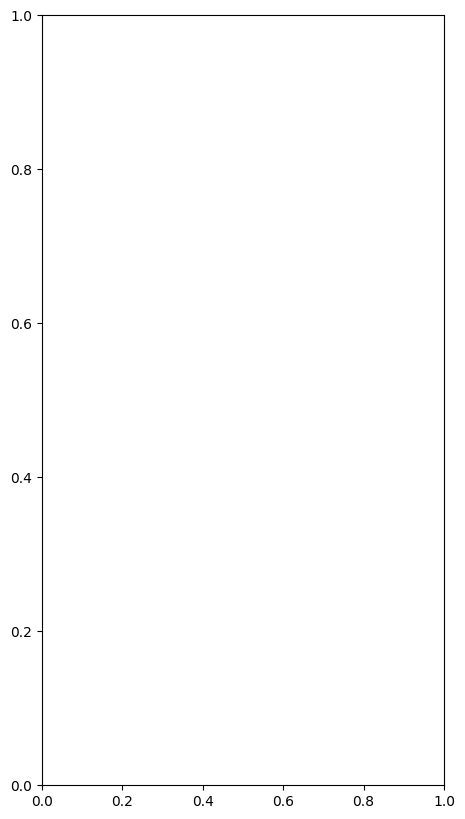

In [45]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load CSV data
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
coastal_df = pd.read_csv(csv_path)

# Check the data structure to confirm columns
print(coastal_df.head())

# Ensure columns are named `latitude` and `longitude` or rename them accordingly
if 'latitude' in coastal_df.columns and 'longitude' in coastal_df.columns:
    # Convert latitude and longitude to a geometry column
    coastal_gdf = gpd.GeoDataFrame(
        coastal_df,
        geometry=gpd.points_from_xy(coastal_df.longitude, coastal_df.latitude),
        crs="EPSG:4326"  # Assuming WGS84 Latitude/Longitude
    )
else:
    print("CSV must contain `latitude` and `longitude` columns.")
    exit()

# Plot the coastal data on a world map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the coastal points
coastal_gdf.plot(ax=ax, color="blue", markersize=1, alpha=0.5, label="Coastal Points")

# Add a world boundary for reference
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, edgecolor="black")

# Configure plot appearance
ax.set_title("Coastal Data Points")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


In [51]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import joblib
import time

# Load data
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N60E003_Map_coast.csv'
df = pd.read_csv(csv_path)
print(f"Number of points loaded: {len(df)}")

# Define the sample point

# Convert DataFrame lat/lon and sample point to radians
df_radians = np.radians(df[['latitude', 'longitude']].values)


# Build the BallTree with Haversine metric
tree = BallTree(df_radians, metric='haversine')

# Save the BallTree
joblib.dump(tree, 'coastal_ball_tree.joblib')
print("BallTree saved successfully.")

# Load the saved BallTree
start_load = time.time()
tree = joblib.load('coastal_ball_tree.joblib')
end_load = time.time()
print(f"Time taken to load BallTree: {end_load - start_load} seconds")

# Query the tree for the closest point
start_query = time.time()
distance_rad, index = tree.query([sample_point_rad], k=1)
distance_km = distance_rad[0][0] * 6371  # Earth's radius in km
end_query = time.time()

# Output the result
print(f"Closest point index: {index[0][0]}")
print(f"Distance to closest point: {distance_km:.2f} km")
print(f"Query time: {end_query - start_query} seconds")


Number of points loaded: 7637843
BallTree saved successfully.
Time taken to load BallTree: 0.08466625213623047 seconds
Closest point index: 2184097
Distance to closest point: 0.31 km
Query time: 0.0006620883941650391 seconds


In [60]:
sample_lat, sample_lon = 62.9297, 3.1532  # Example: Near London
sample_point_rad = np.radians([sample_lat, sample_lon])
distance_rad, index = tree.query([sample_point_rad], k=1)
distance_km = distance_rad[0][0] * 6371  # Earth's radius in km
print(distance_km)


126.7900786264009


In [26]:
import pandas as pd
import numpy as np
from haversine_cython import haversine_cython

# Load CSV containing coastal points (with 'latitude' and 'longitude' columns)
csv_path = 'src/coastal_data_points/ESA_WorldCover_10m_2021_v200_N57W072_Map_coast.csv'
df = pd.read_csv(csv_path)

# Define the sample point (latitude and longitude)
sample_lat, sample_lon = 51.5074, -0.1278  # Example: London

# Convert the latitude and longitude columns to NumPy arrays
lat_array = df['latitude'].to_numpy(dtype=np.float64)
lon_array = df['longitude'].to_numpy(dtype=np.float64)

# Apply the vectorized haversine function
start = time.time()
haversine_cython(lat_array, lon_array, sample_lat, sample_lon)
end = time.time()

print("Time taken:", end - start)
print(df[['latitude', 'longitude', 'haversine_distance_km']].head())


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
import math

def get_filename_from_coordinates(lat, lon):
    """
    Constructs the filename for the H5 file covering the given latitude and longitude,
    rounding down for positive values and up for negative values to include upper bounds.

    Parameters:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.

    Returns:
        str: Filename of the H5 file covering the point.
    """
    # Determine latitude direction and integer degree
    if lat >= 0:
        lat_dir = 'N'
        lat_deg = int(math.floor(lat))
    else:
        lat_dir = 'S'
        lat_deg = int(math.ceil(-lat))

    # Determine longitude direction and integer degree
    if lon >= 0:
        lon_dir = 'E'
        lon_deg = int(math.floor(lon))
    else:
        lon_dir = 'W'
        lon_deg = int(math.ceil(-lon))

    # Format degrees with leading zeros
    lat_str = f"{lat_dir}{lat_deg:02d}"
    lon_str = f"{lon_dir}{lon_deg:03d}"

    # Construct the filename
    filename = f"Ai2_WorldCover_10m_2024_v1_{lat_str}{lon_str}_Map.h5"

    return filename


In [17]:
from pathlib import Path
for filename in Path('/home/patrickb/litus/data/h5s').glob('*.h5'):
    print(filename_to_bounds(filename))

{'filename': 'Ai2_WorldCover_10m_2024_v1_N61W073_Map', 'lat_min': 61, 'lat_max': 62, 'lon_min': -73, 'lon_max': -72}
{'filename': 'Ai2_WorldCover_10m_2024_v1_N63W161_Map', 'lat_min': 63, 'lat_max': 64, 'lon_min': -161, 'lon_max': -160}
{'filename': 'Ai2_WorldCover_10m_2024_v1_N44E025_Map', 'lat_min': 44, 'lat_max': 45, 'lon_min': 25, 'lon_max': 26}
{'filename': 'Ai2_WorldCover_10m_2024_v1_S90E091_Map', 'lat_min': -90, 'lat_max': -89, 'lon_min': 91, 'lon_max': 92}
{'filename': 'Ai2_WorldCover_10m_2024_v1_S06E155_Map', 'lat_min': -6, 'lat_max': -5, 'lon_min': 155, 'lon_max': 156}
{'filename': 'Ai2_WorldCover_10m_2024_v1_N68E148_Map', 'lat_min': 68, 'lat_max': 69, 'lon_min': 148, 'lon_max': 149}
{'filename': 'Ai2_WorldCover_10m_2024_v1_N07W006_Map', 'lat_min': 7, 'lat_max': 8, 'lon_min': -6, 'lon_max': -5}
{'filename': 'Ai2_WorldCover_10m_2024_v1_N33E000_Map', 'lat_min': 33, 'lat_max': 34, 'lon_min': 0, 'lon_max': 1}
{'filename': 'Ai2_WorldCover_10m_2024_v1_S02E101_Map', 'lat_min': -2, 'l

In [ ]:
import time
from pathlib import Path
import h5py
import h5py
import rasterio.transform
import math
import numpy as np
from sklearn.neighbors import BallTree
import joblib
from pathlib import Path
import time

land_water_mapping = {
    1: 'land',
    10: 'Tree cover',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bare/sparse vegetation',
    70: 'Snow and Ice',
    80: 'Permanent water bodies',
    90: 'Herbaceous wetland',
    95: 'Mangroves',
    100: 'Moss and lichen',
}
    # with h5py.File('/home/patrickb/litus/data/h5s/Ai2_WorldCover_10m_2024_v1_N00E010_Map.h5', 'r') as hdf:
    #     band_data = hdf['band_data']
    #     geotransform = hdf['geotransform'][:]

    #     # Function to query the value from HDF5 using lat/lon
    #     def query_value(lon, lat):
    #         # Convert geographic coordinates to image coordinates (row, col)
    #         row, col = ~rasterio.transform.Affine(*geotransform) * (lon, lat)
    #         return band_data[int(row), int(col)]

    #     # Query an example coordinate
    #     lon, lat = 6.5, 0.5
    #     print(query_value(lon, lat))

def h5_to_integer(filename, lon, lat):
    filename = Path('data/h5s') / filename
    with h5py.File(filename, 'r') as hdf:
        band_data = hdf['band_data']
        geotransform = hdf['geotransform'][:]

        # Function to query the value from HDF5 using lat/lon
        def query_value(lon, lat):
            # Convert geographic coordinates to image coordinates (row, col)
            row, col = ~rasterio.transform.Affine(*geotransform) * (lon, lat)
            return band_data[int(row), int(col)]

        # Query an example coordinate
        class_id = query_value(lon, lat)

    return class_id

In [3]:

filename = '/home/patrickb/litus/data/h5s/Ai2_WorldCover_10m_2024_v1_N00E010_Map.h5'
latitude = 0.1
longitude =  10

%timeit h5_to_integer(filename, longitude, latitude)

385 μs ± 4.02 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [64]:
import joblib

# Save BallTree with optimized joblib settings for fast loading
def save_ball_tree_fast(ball_tree, filename):
    joblib.dump(ball_tree, filename, compress=0, protocol=5)  # Disable compression, use protocol 4 for speed

# Load the BallTree
def load_ball_tree_fast(filename):
    return joblib.load(filename)


In [65]:
save_ball_tree_fast(tree, 'tree.joblib')

In [66]:
%timeit load_ball_tree_fast('tree.joblib')

4.65 ms ± 11.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
import h5py
import numpy as np
from sklearn.neighbors import BallTree

# Save Ball Tree data in HDF5 format
def save_ball_tree_hdf5(ball_tree, filename):
    with h5py.File(filename, 'w') as f:
        f.create_dataset('data', data=ball_tree.data)
        f.create_dataset('leaf_size', data=ball_tree.leaf_size)
        f.create_dataset('metric', data=ball_tree.metric.pairwise)

# Load Ball Tree data from HDF5 format
def load_ball_tree_hdf5(filename):
    with h5py.File(filename, 'r') as f:
        data = f['data'][:]
        leaf_size = int(f['leaf_size'][()])
        metric = f['metric'][()]
    return BallTree(data, leaf_size=leaf_size, metric=metric)


In [41]:
save_ball_tree_hdf5(tree, 'balltree.h5')

AttributeError: 'BallTree' object has no attribute 'leaf_size'

In [51]:
import h5py
import numpy as np
from sklearn.neighbors import BallTree

# Save Ball Tree data in HDF5 format
def save_ball_tree_hdf5(ball_tree, filename, metric='haversine'):
    with h5py.File(filename, 'w') as f:
        f.create_dataset('data', data=ball_tree.data)
        # f.attrs['leaf_size'] = leaf_size
        f.attrs['metric'] = metric

# Load Ball Tree data from HDF5 format
def load_ball_tree_hdf5(filename):
    with h5py.File(filename, 'r') as f:
        data = f['data'][:]
        # leaf_size = int(f.attrs['leaf_size'])
        metric = f.attrs['metric']
    return BallTree(data,  metric=metric)


In [52]:
save_ball_tree_hdf5(tree, 'temp.h5')

In [54]:
%timeit load_ball_tree_hdf5('temp.h5')

662 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
